In [1]:
# ============================================================
# 1. Mount Google Drive
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset in Drive
DATASET_PATH = "/content/drive/MyDrive/CivicLensDataset"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)


Found 6723 images belonging to 5 classes.
Found 1677 images belonging to 5 classes.


In [4]:
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(33.615), 1: np.float64(0.4800428418421992), 2: np.float64(0.3675779114270093), 3: np.float64(11.205), 4: np.float64(12.928846153846154)}


In [5]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # transfer learning first

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
checkpoint_path = "/content/drive/MyDrive/best_model.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stop]


In [7]:
if os.path.exists(checkpoint_path):
    print("Checkpoint found — loading weights and resuming training...")
    model.load_weights(checkpoint_path)
else:
    print("No checkpoint found, training from scratch.")


No checkpoint found, training from scratch.


In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6269 - loss: 1.3163 
Epoch 1: val_accuracy improved from -inf to 0.95528, saving model to /content/drive/MyDrive/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 5526s 26s/step - accuracy: 0.6275 - loss: 1.3141 - val_accuracy: 0.9553 - val_loss: 0.1664
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.8873 - loss: 0.3514
Epoch 2: val_accuracy did not improve from 0.95528
211/211 ━━━━━━━━━━━━━━━━━━━━ 149s 708ms/step - accuracy: 0.8873 - loss: 0.3513 - val_accuracy: 0.9547 - val_loss: 0.1507
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9189 - loss: 0.2887
Epoch 3: val_accuracy improved from 0.95528 to 0.97734, saving model to /content/drive/MyDrive/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 711ms/step - accuracy: 0.9189 - loss: 0.2886 - val_accuracy: 0.9773 - val_loss: 0.0741
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9332 - loss: 0.2450
Epoch 4: val_accuracy did not improve from 0.97734
211/211 ━━━━━━━━━━━━━━━━━━━━ 154s 730ms/step - accuracy: 0.9332 - loss: 0.2448 - val_accuracy: 0.9612 - val_loss: 0.1360
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9375 - loss: 0.1961
Epoch 5: val_accuracy did not improve from 0.97734
211/211 ━━━━━━━━━━━━━━━━━━━━ 149s 707ms/step - accuracy: 0.9376 - loss: 0.1960 - val_accuracy: 0.9714 - val_loss: 0.0897
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9513 - loss: 0.1572
Epoch 6: val_accuracy improved from 0.97734 to 0.98092, saving model to /content/drive/MyDrive/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 710ms/step - accuracy: 0.9513 - loss: 0.1572 - val_accuracy: 0.9809 - val_loss: 0.0695
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9606 - loss: 0.1111
Epoch 7: val_accuracy did not improve from 0.98092
211/211 ━━━━━━━━━━━━━━━━━━━━ 149s 706ms/step - accuracy: 0.9606 - loss: 0.1111 - val_accuracy: 0.9744 - val_loss: 0.0874
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9555 - loss: 0.1483
Epoch 8: val_accuracy did not improve from 0.98092
211/211 ━━━━━━━━━━━━━━━━━━━━ 146s 690ms/step - accuracy: 0.9555 - loss: 0.1482 - val_accuracy: 0.9797 - val_loss: 0.0638
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9637 - loss: 0.0998
Epoch 9: val_accuracy improved from 0.98092 to 0.98271, saving model to /content/drive/MyDrive/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 146s 694ms/step - accuracy: 0.9637 - loss: 0.0999 - val_accuracy: 0.9827 - val_loss: 0.0500
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9708 - loss: 0.0667
Epoch 10: val_accuracy did not improve from 0.98271
211/211 ━━━━━━━━━━━━━━━━━━━━ 146s 690ms/step - accuracy: 0.9708 - loss: 0.0668 - val_accuracy: 0.9809 - val_loss: 0.0609


In [9]:
final_model_path = "/content/drive/MyDrive/final_model_ResNet50.h5"
model.save(final_model_path)

print("Final model saved at:", final_model_path)


Final model saved at: /content/drive/MyDrive/final_model_ResNet50.h5


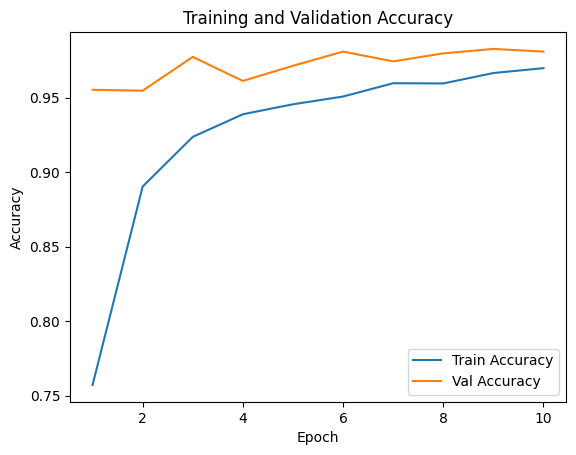

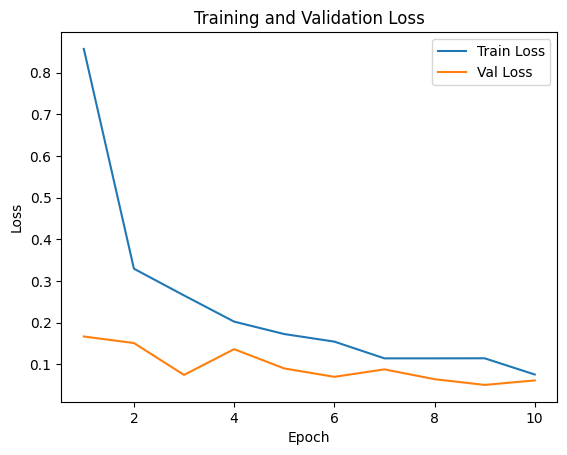

In [10]:
import matplotlib.pyplot as plt

# history is the object returned by model.fit(...)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Found 1677 images belonging to 5 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step
Class indices: {'Broken Missing Streetlight': 0, 'Garbages': 1, 'Others': 2, 'Potholes': 3, 'Waterlogging': 4}
Confusion Matrix:
 [[  9   0   0   0   0]
 [  0 690   0  10   0]
 [  3   0 898   6   7]
 [  0   1   0  28   0]
 [  0   0   1   1  23]]


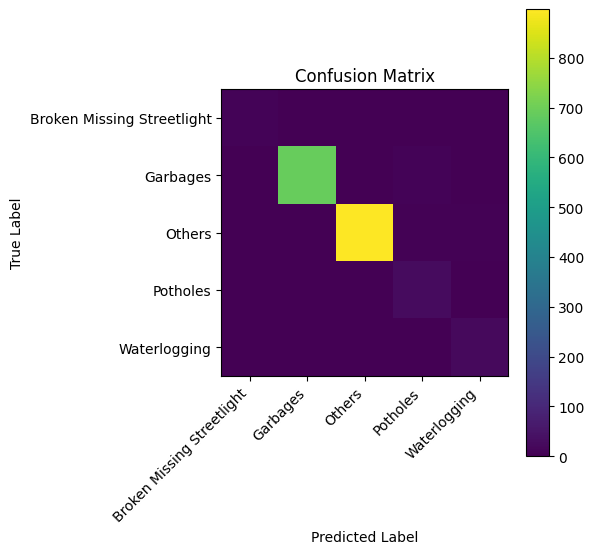


Classification Report:

                            precision    recall  f1-score   support

Broken Missing Streetlight       0.75      1.00      0.86         9
                  Garbages       1.00      0.99      0.99       700
                    Others       1.00      0.98      0.99       914
                  Potholes       0.62      0.97      0.76        29
              Waterlogging       0.77      0.92      0.84        25

                  accuracy                           0.98      1677
                 macro avg       0.83      0.97      0.89      1677
              weighted avg       0.99      0.98      0.98      1677



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Recreate validation generator with shuffle=False
val_gen_cm = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

# Predict
y_prob = model.predict(val_gen_cm)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen_cm.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_gen_cm.class_indices.keys())
print("Class indices:", val_gen_cm.class_indices)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Optional: detailed report (precision, recall, f1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Mapping from index → class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
print(idx_to_class)

def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_class = idx_to_class[pred_idx]
    confidence = float(np.max(preds))

    print(f"Predicted class: {pred_class} (confidence: {confidence:.4f})")
    return pred_class, confidence

# Example usage:
test_img_path = "/content/000007.jpg"
predict_single_image(test_img_path, model)

test_img_path = "/content/06_02_0005.png"
predict_single_image(test_img_path, model)


{0: 'Broken Missing Streetlight', 1: 'Garbages', 2: 'Others', 3: 'Potholes', 4: 'Waterlogging'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: Garbages (confidence: 0.9979)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Others (confidence: 0.9978)


('Others', 0.9977607727050781)